# Gender classification

#### Description

This is a simple gender classification based on the mean pitch level of the frames.

A model is trained by using an optimization function on the mean pitch level.

#### Methods

Librosa (Pyin), optimzation function, model classing

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
plt.rcParams["figure.facecolor"] = "w"

from pathlib import Path

import librosa 
import librosa.display

## Read train csv file

In [2]:
data_dir = Path("../data")

df_train = pd.read_csv(data_dir / "cv-valid-train.csv")
print(len(df_train))
df_train.head()

195776


,filename,text,up_votes,down_votes,age,gender,accent,duration
0,cv-valid-train/sample-000000.mp3,learn to recognize omens and follow them the o...,1,0,NaN,NaN,NaN,NaN
1,cv-valid-train/sample-000001.mp3,everything in the universe evolved he said,1,0,NaN,NaN,NaN,NaN
2,cv-valid-train/sample-000002.mp3,you came so that you could learn about your dr...,1,0,NaN,NaN,NaN,NaN
3,cv-valid-train/sample-000003.mp3,so now i fear nothing because it was those ome...,1,0,NaN,NaN,NaN,NaN
4,cv-valid-train/sample-000004.mp3,if you start your emails with greetings let me...,3,2,NaN,NaN,NaN,NaN


## Display examples of speeches
Plot one female frame and one male frame. 

We estimate the pitch using the Yin and Pyin algorithms, and compare the results. The pitch estimations are plotted onto the spectrogram. The flags drawn on the audio signal originate from the Pyin algorithm.

In [3]:
df_gender = df_train[~df_train.gender.isna()]
print(len(df_gender))

74059


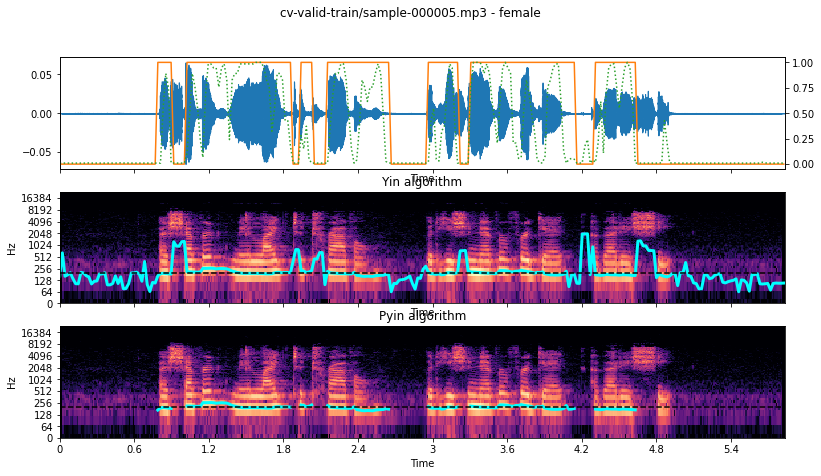

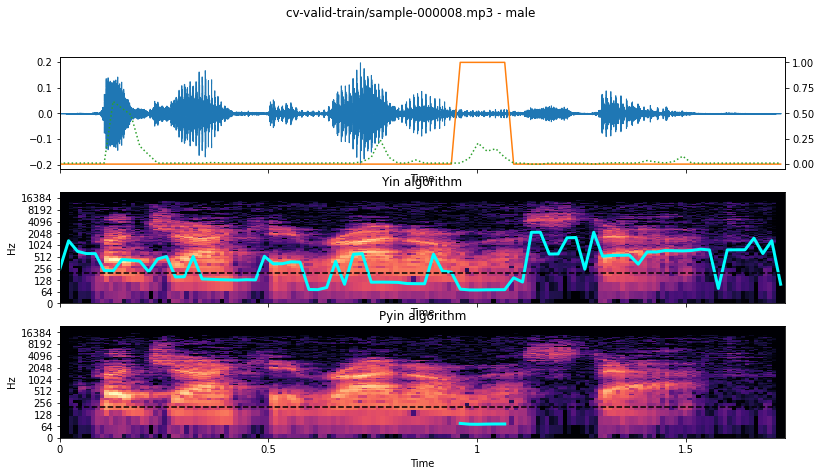

In [4]:
row_female = df_gender[df_gender.gender == "female"].iloc[0]
row_male = df_gender[df_gender.gender == "male"].iloc[0]

for row in [row_female, row_male]:
    audio_file = data_dir / row.filename

    signal, sr = librosa.load(str(audio_file.resolve()), sr=None)

    ## Yin algorithm
    # use the recommended C2 (~65 Hz) and C7 (~2093 Hz) for fmin and fmax
    # default frame length is 2048 for sr=22050
    frame_length = 4096
    f0_yin = librosa.yin(signal, fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C7'), sr=sr, frame_length=frame_length)
    times_f0_yin = librosa.times_like(f0_yin, sr=sr, hop_length=frame_length//4)

    ## Pyin algorithm
    # Gives the advantage to return a flag indicating the frame is voiced or not
    frame_length = 4096
    f0_pyin, voiced_flag, voiced_probs = librosa.pyin(signal, fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C7'), sr=sr, frame_length=frame_length)
    times_f0_pyin = librosa.times_like(f0_pyin, sr=sr, hop_length=frame_length//4)


    ## Spectrogram
    spec = librosa.amplitude_to_db(np.abs(librosa.stft(signal, n_fft=1024, hop_length=512)), ref=np.max)

    ## Plot
    fig, ax = plt.subplots(3, 1, figsize=(13, 7), sharex=True)
    fig.suptitle(f"{row.filename} - {row.gender}")
    librosa.display.waveshow(signal, sr=sr, x_axis="time", ax=ax[0])
    axright = ax[0].twinx()
    axright.plot(times_f0_pyin, voiced_flag, color="C1")
    axright.plot(times_f0_pyin, voiced_probs, color="C2", linestyle=":")
    librosa.display.specshow(spec,sr=sr, hop_length=512, x_axis='time', y_axis='log', ax=ax[1])
    ax[1].plot(times_f0_yin, f0_yin, label='f0', color='cyan', linewidth=3)
    ax[1].plot(times_f0_yin, [200] * len(times_f0_yin), color="k", linestyle="--")
    ax[1].set_title("Yin algorithm")
    librosa.display.specshow(spec,sr=sr, hop_length=512, x_axis='time', y_axis='log', ax=ax[2])
    ax[2].plot(times_f0_pyin, f0_pyin, label='f0', color='cyan', linewidth=3)
    ax[2].plot(times_f0_pyin, [200] * len(times_f0_pyin), color="k", linestyle="--")
    ax[2].set_title("Pyin algorithm")

## Feature engineering
Build the inputs for a ML model. The mean pitch is calculated using the Pyin algorithm. 

In [5]:
import warnings
from joblib import Parallel, delayed

gender_map = {
    "female": 0,
    "male": 1
}

def load_audio(filename):
    audio_file = data_dir / filename
    # ignore known warning caused by PySoundFile not able to read .mp3 files
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        signal, sr = librosa.load(str(audio_file.resolve()), sr=None)
    return signal, sr

def apply_pyin(signal, sr):    
    ## Pyin algorithm
    # used over the Yin algorithm because it gives the advantage to return a flag indicating the frame is voiced or not
    # use the recommended C2 (~65 Hz) and C7 (~2093 Hz) for fmin and fmax
    # default frame length is 2048 for sr=22050
    frame_length = 2048 * (sr//22050)
    f0, voiced_flag, voiced_probs = librosa.pyin(signal, fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C7'), sr=sr, frame_length=frame_length)
    return f0, voiced_flag, voiced_probs

def process_audio(df_row):
    signal, sr = load_audio(df_row.filename)
    f0, _, _ = apply_pyin(signal, sr)  # voiced_flags and voiced_probs are unused here
    if not np.all(np.isnan(f0)): 
        return np.nanmean(f0), gender_map[df_row.gender]
    else:
        # return the filename in case no voice was detected
        return None, df_row.filename


#### Build feature set 
run_parallel = True
size_include = 200

x, y = [], []
silent_frames = []

if run_parallel:
    processed = Parallel(n_jobs=-1)(delayed(process_audio)(row) for row in df_gender.iloc[:size_include].itertuples())
    for mean_pitch, gender in processed:
        # only include voiced frames
        if mean_pitch is not None:
            x.append(mean_pitch)
            y.append(gender)
        else:
            silent_frames.append(gender)

else:
    for row in df_gender.iloc[:size_include].itertuples():
        mean_pitch, gender = process_audio(row)
        # only include voiced frames
        if mean_pitch is not None:
            x.append(mean_pitch)
            y.append(gender)
        else:
            silent_frames.append(gender)

print(f"Size of data: {len(x)}")

Size of data: 200


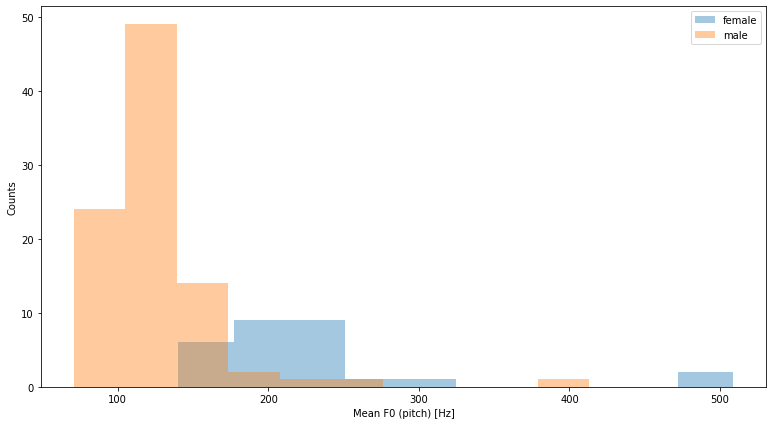

In [10]:
## Feature inspection
from sklearn.model_selection import train_test_split
x = np.array(x)
y = np.array(y)
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.4, stratify=y)

xfemale = X_train[np.where(y_train == 0)[0]]
xmale = X_train[np.where(y_train == 1)[0]]

fig, ax = plt.subplots(figsize=(13, 7))
ax.hist(xfemale, alpha=0.4, label="female")
ax.hist(xmale, alpha=0.4, label="male")
ax.set_xlabel("Mean F0 (pitch) [Hz]")
ax.set_ylabel("Counts")
ax.legend()

## Train a model
Use an optimization function to derive the pitch level that best discrimates gender

In [7]:
from scipy.optimize import minimize

class GenderClassifier:
    def __init__(self, pitch_thresh_estim):
        self.pitch_thresh_estim = pitch_thresh_estim        

    def fit(self, X, y):
        X = np.array(X)
        y = np.array(y)
        res = minimize(self.loss, [self.pitch_thresh_estim], args=(X, y), method='nelder-mead', options={'xatol': 1e-8, 'disp': True})
        if res.success:
            self.pitch_thresh_optim = res.x[0]
        else:
            raise ValueError(f"Could not train - {res.message}")

    def predict(self, X, pitch_thresh=None):
        X = np.array(X)
        y = np.zeros(len(X))
        if pitch_thresh is None:
            pitch_thresh = self.pitch_thresh_optim
        y[np.where(X < pitch_thresh)[0]] = 1    
        return y       

    def loss(self, pitch_thresh, X, y):
        # returns the amount of mistakes
        pitch_thresh = np.atleast_1d(pitch_thresh)
        ypred = self.predict(X, pitch_thresh=pitch_thresh[0])  
        return np.sum(y != ypred)

    def score(self, X, y):
        # returns the accuracy
        return 1 - self.loss(self.pitch_thresh_optim, X, y) / len(y)

In [15]:
clf = GenderClassifier(200)  # rough estimation of pitch threshold is 200 Hz
print(f"Training on {len(y_train)} data ...")
clf.fit(X_train, y_train)
print(f"Optimal pitch threshold level found at {clf.pitch_thresh_optim} Hz")
score = clf.score(X_test, y_test)
print(f"Score on test set: {score} (test size: {len(y_test)})")

Training on 120 data ...
Optimization terminated successfully.
         Current function value: 10.000000
         Iterations: 34
         Function evaluations: 96
Optimal pitch threshold level found at 165.0 Hz
Score on test set: 0.9375 (test size: 80)


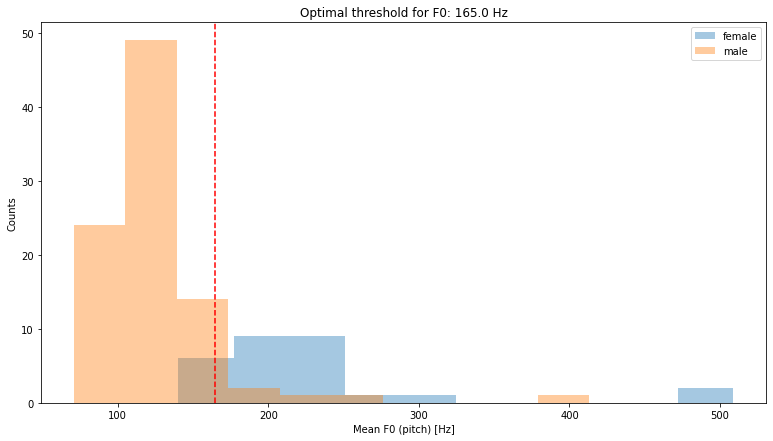

In [14]:
fig, ax = plt.subplots(figsize=(13, 7))
ax.hist(xfemale, alpha=0.4, label="female")
ax.hist(xmale, alpha=0.4, label="male")
ylims = ax.get_ylim()
ax.vlines(clf.pitch_thresh_optim, ylims[0], ylims[1], color="r", linestyle="--")
ax.set_ylim(ylims)
ax.set_xlabel("Mean F0 (pitch) [Hz]")
ax.set_ylabel("Counts")
ax.set_title(f"Optimal threshold for F0: {clf.pitch_thresh_optim} Hz")
ax.legend()